In [1]:
""" Main improvements:
    * include 2 bins at extremes to differentiate between them
        (all 0s become identical ay extremes and no gradient)
    * use torch scatter and less ops in readout.
""";

In [2]:
import torch
import torch.nn as nn
from torch_scatter import scatter
import numpy as np
import matplotlib.pyplot as plt
# partial scatter func
from functools import partial

In [3]:
device="cpu"

In [35]:
class Diff_Hist(nn.Module):
    def __init__(self, centers={-10: 0.5, -5: 0.5, 0: 0.5, 5: 0.5, 10: 0.5},
                 opennes=False):
        super(Diff_Hist, self).__init__()
        """ centers: dict of center:scale
            opennes: whether to use symmetrical bins
                or sigmoids at different locations
        """
        # save params
        self.true_centers = sorted(list(centers.keys()))
        self.scales       = list(centers.values())
        self.opennes      = opennes
        
        # augmenting sigmoid so higher gradient and localized feats
        self.max_scaler   = [1 for c in self.scales]
        self.sigmoid_x    = lambda y, scaler: 1/(1+torch.exp(-scaler*y))
        self.max_scaler   = [torch.max(self.func(torch.arange(start=-10, end=10, step=1e-3), scale, 1))
                             for scale in self.scales]
        self.sigmoid_x    = lambda y, scaler: 1/(1+torch.exp(-scaler*y))
        
        # our function is centered @ 0.5 by default, but not at extremes (then it's centered @ 0)
        self.centers      = [self.true_centers[0]] + \
                            list(0.5 + np.array(self.true_centers[1:-1])) + \
                            [self.true_centers[-1]]
        self.n_centers    = len(self.centers)

    def forward(self, x, reduce="mean"):
        r""" reduces dim=0 as a set of bins. designed for 2d outs. """
        x_shape = x.shape
        out     = torch.zeros(x_shape[0], self.n_centers, *x.shape[1:], device=device)
        for i, center in enumerate(self.centers):
            # decide conditions for open - end
            open_right_end = self.opennes and self.true_centers[i]<0 
            open_left_end  = self.opennes and self.true_centers[i]>0
            # add the 2 extremes to differentiate btween them (+/- and right/left is inversed)
            if i == 0 or open_right_end:
                out[:, i] = self.make_right_extreme(x, self.true_centers[i], self.scales[i])
            elif i == self.n_centers-1 or open_left_end:
                out[:, i] = self.make_left_extreme(x, self.true_centers[i], self.scales[i])
            else:
                out[:, i] = self.make_bin(x, center, self.scales[i], self.max_scaler[i])
            
        # summarizes a set of (n_examples, n_feats) into a single (n_centers, n_feats)
        if reduce == "sum" or reduce == "add":
            return out.sum(dim=0)
        elif reduce:
            return out.mean(dim=0)
        return out

    def make_bin(self, x, center, scale, max_scaler):
        return self.func(x+center, scale, max_scaler)
    
    def make_left_extreme(self, x, center, scale):
        return (1-self.sigmoid_x(x+center, scale))
    
    def make_right_extreme(self, x, center, scale):
        return self.sigmoid_x(x+center, scale)
        
    def func(self, x, scale, max_scaler):
        # perform minmax scaling so max is 1 and min (is already) 0
        return (self.sigmoid_x(x, scale)-self.sigmoid_x(x-1, scale))/max_scaler

    def __repr__(self):
        return "Simple differentiable histogram layer:" + \
               str({"centers"    : self.true_centers,
                    "exp_scales" : self.scales, 
                    "max_scaler" : self.max_scaler})

In [36]:
class Readout_Hist(nn.Module):
    def __init__(self, centers, reduce=None):
        super(Readout_Hist, self).__init__()
        # save centers
        self.true_centers  = centers
        self.n_centers     = len(centers)
        self.diff_hist     = Diff_Hist(centers=centers)
        # reduces nodes -> graph by gather/scatter
        if reduce is None:
            reduce = partial(scatter, reduce="mean")
        self.reduce_scheme = reduce

    def forward(self, x, batch=None, bsize=None, dim=0):
        r""" reduces dim=0 by gather/scatter each node. designed for 2d outs. """
        hist_aux = self.diff_hist(x, reduce=None)
        hist_aux = hist_aux.reshape(hist_aux.shape[0], -1)
        return self.reduce_scheme(hist_aux, batch, dim_size=bsize, dim=dim)

    def __repr__(self):
        return "Readout by histogram:" + str({"centers": self.true_centers})
    
    
#    """ don't reduce if used for readout-scatter. """
#        if reduce is None:
#            return self.func(x+center)

In [37]:
# center:scale (center of the hist bin and exponential scale of the sigmoidal functions)
# the 2 centers at the extremes have an open end
#
# recommendations: (delta=2, scale=2) (delta=3.5, scale=1) (delta=5, scale=0.5)
centers = {-10: 0.5, -7: 0.3, -5: 0.5, 0: 0.5, 5: 0.5, 7: 0.3, 10: 0.5}
hister  = Diff_Hist(centers=centers, opennes=True)#[-8,-6,-4,-2,0,2,4,6,8])

(tensor([[0.0080, 0.0080, 0.0075, 0.0071, 0.0078],
         [0.1164, 0.1168, 0.1129, 0.1096, 0.1137],
         [0.0880, 0.0882, 0.0831, 0.0790, 0.0853],
         [0.9474, 0.9519, 0.9548, 0.9542, 0.9405],
         [0.0778, 0.0762, 0.0806, 0.0848, 0.0827],
         [0.1082, 0.1072, 0.1107, 0.1142, 0.1119],
         [0.0070, 0.0068, 0.0073, 0.0077, 0.0075]]),
 Simple differentiable histogram layer:{'centers': [-10, -7, -5, 0, 5, 7, 10], 'exp_scales': [0.5, 0.3, 0.5, 0.5, 0.5, 0.3, 0.5], 'max_scaler': [tensor(0.1244), tensor(0.0749), tensor(0.1244), tensor(0.1244), tensor(0.1244), tensor(0.0749), tensor(0.1244)]})

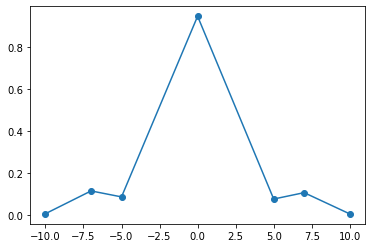

In [38]:
inputs = torch.randn(87,5)
# plot and print()
histed = hister(inputs)
plt.plot(hister.true_centers, histed[:, 0].flatten(), "o-")
histed, hister

In [39]:
%%timeit
# timing - only the histogram, not the readout
for i in range(10):
    histed = hister(inputs)

3.45 ms ± 170 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
